# Clustering substractivo

In [1]:
"""Subtractive Clustering Algorithm
"""
__author__ = 'Daniel Albornoz'


import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance_matrix

def SubstactiveClustering(data, Ra, Rb=0, AcceptRatio=0.3, RejectRatio=0.1): #crea una funcion en la que hace el clusterin substractivo con los parametros datos,RA,RB, Racept, Rreject,
    if Rb==0:
        Rb = Ra*1.15

    scaler = MinMaxScaler()
    scaler.fit(data)
    ndata = scaler.transform(data)

    # 14/05/2020 cambio list comprehensions por distance matrix
    #P = np.array([np.sum([np.exp(-(np.linalg.norm(u-v)**2)/(Ra/2)**2) for v in ndata]) for u in ndata])
    #print(P)
    P = distance_matrix(ndata,ndata)
    alpha=(Ra/2)**2
    P = np.sum(np.exp(-P**2/alpha),axis=0)

    centers = []
    i=np.argmax(P)
    C = ndata[i]
    p=P[i]
    centers = [C]

    continuar=True
    restarP = True
    while continuar:
        pAnt = p
        if restarP:
            P=P-p*np.array([np.exp(-np.linalg.norm(v-C)**2/(Rb/2)**2) for v in ndata])
        restarP = True
        i=np.argmax(P)
        C = ndata[i]
        p=P[i]
        if p>AcceptRatio*pAnt:
            centers = np.vstack((centers,C))
        elif p<RejectRatio*pAnt:
            continuar=False
        else:
            dr = np.min([np.linalg.norm(v-C) for v in centers])
            if dr/Ra+p/pAnt>=1:
                centers = np.vstack((centers,C))
            else:
                P[i]=0
                restarP = False
        if not any(v>0 for v in P):
            continuar = False
    distancias = [[np.linalg.norm(p-c) for p in ndata] for c in centers]
    labels = np.argmin(distancias, axis=0)
    centers = scaler.inverse_transform(centers)
    return labels, centers

# c1 = np.random.rand(15,2)+[1,1]
# c2 = np.random.rand(10,2)+[10,1.5]
# c3 = np.random.rand(5,2)+[4.9,5.8]
# m = np.append(c1,c2, axis=0)
# m = np.append(m,c3, axis=0)

# r,c = SubstactiveClustering(m,2)

# plt.figure()
# plt.scatter(m[:,0],m[:,1])
# plt.scatter(c[:,0],c[:,1], marker='X')
# print(c)

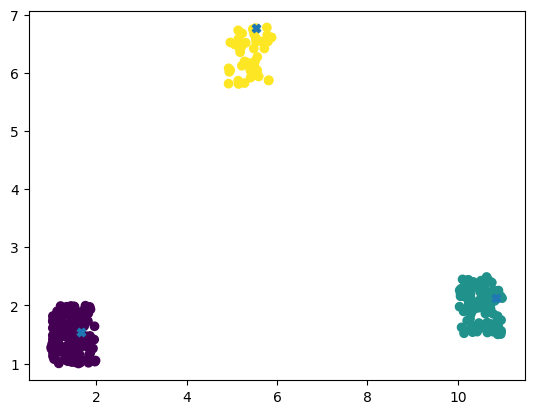

In [ ]:
c1 = np.random.rand(150,2)+[1,1]
c2 = np.random.rand(100,2)+[10,1.5]
c3 = np.random.rand(50,2)+[4.9,5.8]
m = np.append(c1,c2, axis=0)
m = np.append(m,c3, axis=0)

r,c = SubstactiveClustering(m,1)

plt.figure()
plt.scatter(m[:,0],m[:,1], c=r)
plt.scatter(c[:,0],c[:,1], marker='X')

# GEN Fis
## Generación de FIS a partir de agrupamiento de los datos de entrenamiento

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed May  6 17:56:16 2020

@author: Daniel Albornoz

Implementación similar a genfis2 de Matlab.
Sugeno type FIS. Generado a partir de clustering substractivo.

"""
__author__ = 'Daniel Albornoz'

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import time

def gaussmf(data, mean, sigma):
    return np.exp(-((data - mean)**2.) / (2 * sigma**2.))

class fisRule:
    def __init__(self, centroid, sigma):
        self.centroid = centroid
        self.sigma = sigma

class fisInput:
    def __init__(self, min,max, centroids):
        self.minValue = min
        self.maxValue = max
        self.centroids = centroids


    def view(self):
        x = np.linspace(self.minValue,self.maxValue,20)
        plt.figure()
        for m in self.centroids:
            s = (self.minValue-self.maxValue)/8**0.5
            y = gaussmf(x,m,s)
            plt.plot(x,y)

class fis:
    def __init__(self):
        self.rules=[]
        self.memberfunc = []
        self.inputs = []



    def genfis(self, data, radii):

        start_time = time.time()
        labels, cluster_center = SubstactiveClustering(data, radii)

        print("--- %s seconds ---" % (time.time() - start_time))
        n_clusters = len(cluster_center)

        cluster_center = cluster_center[:,:-1]
        P = data[:,:-1]
        #T = data[:,-1]
        maxValue = np.max(P, axis=0)
        minValue = np.min(P, axis=0)

        self.inputs = [fisInput(maxValue[i], minValue[i],cluster_center[:,i]) for i in range(len(maxValue))]
        self.rules = cluster_center
        self.entrenar(data)

    def entrenar(self, data):
        P = data[:,:-1]
        T = data[:,-1]
        #___________________________________________
        # MINIMOS CUADRADOS (lineal)
        sigma = np.array([(i.maxValue-i.minValue)/np.sqrt(8) for i in self.inputs])
        f = [np.prod(gaussmf(P,cluster,sigma),axis=1) for cluster in self.rules]

        nivel_acti = np.array(f).T
        print("nivel acti")
        print(nivel_acti)
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))
        print("sumMu")
        print(sumMu)
        P = np.c_[P, np.ones(len(P))]
        n_vars = P.shape[1]

        orden = np.tile(np.arange(0,n_vars), len(self.rules))
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]


        A = acti*inp/sumMu

        # A = np.zeros((N, 2*n_clusters))
        # for jdx in range(n_clusters):
        #     for kdx in range(nVar):
        #         A[:, jdx+kdx] = nivel_acti[:,jdx]*P[:,kdx]/sumMu
        #         A[:, jdx+kdx+1] = nivel_acti[:,jdx]/sumMu

        b = T

        solutions, residuals, rank, s = np.linalg.lstsq(A,b,rcond=None)
        self.solutions = solutions #.reshape(n_clusters,n_vars)
        print(solutions)
        return 0

    def evalfis(self, data):
        sigma = np.array([(input.maxValue-input.minValue) for input in self.inputs])/np.sqrt(8)
        f = [np.prod(gaussmf(data,cluster,sigma),axis=1) for cluster in self.rules]
        nivel_acti = np.array(f).T
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))

        P = np.c_[data, np.ones(len(data))]

        n_vars = P.shape[1]
        n_clusters = len(self.rules)

        orden = np.tile(np.arange(0,n_vars), n_clusters)
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]
        coef = self.solutions

        return np.sum(acti*inp*coef/sumMu,axis=1)


    def viewInputs(self):
        for input in self.inputs:
            input.view()






# Test genfis 1 entrada

--- 0.026242494583129883 seconds ---
nivel acti
[[0.38659407 0.02710355 0.99506286]
 [0.39420445 0.02815555 0.99637033]
 [0.40188346 0.02924247 0.997478  ]
 [0.40962928 0.03036523 0.99838518]
 [0.41744006 0.03152472 0.99909135]
 [0.42531385 0.03272187 0.99959605]
 [0.43324862 0.03395763 0.999899  ]
 [0.44124228 0.03523293 1.        ]
 [0.44929266 0.03654875 0.999899  ]
 [0.4573975  0.03790605 0.99959605]
 [0.46555448 0.03930581 0.99909135]
 [0.47376122 0.04074903 0.99838518]
 [0.48201524 0.04223671 0.997478  ]
 [0.490314   0.04376986 0.99637033]
 [0.4986549  0.0453495  0.99506286]
 [0.50703524 0.04697665 0.99355637]
 [0.51545229 0.04865236 0.99185177]
 [0.52390321 0.05037766 0.98995009]
 [0.53238513 0.05215362 0.98785247]
 [0.54089509 0.05398127 0.98556018]
 [0.54943007 0.05586168 0.9830746 ]
 [0.557987   0.05779592 0.9803972 ]
 [0.56656273 0.05978505 0.97752961]
 [0.57515406 0.06183016 0.97447352]
 [0.58375773 0.0639323  0.97123076]
 [0.59237041 0.06609256 0.96780327]
 [0.60098875 0.0

array([ -606.22688781,  6068.16565534,  -434.35726888,   -13.48313224,
        -433.29044165, -6495.3126572 ])

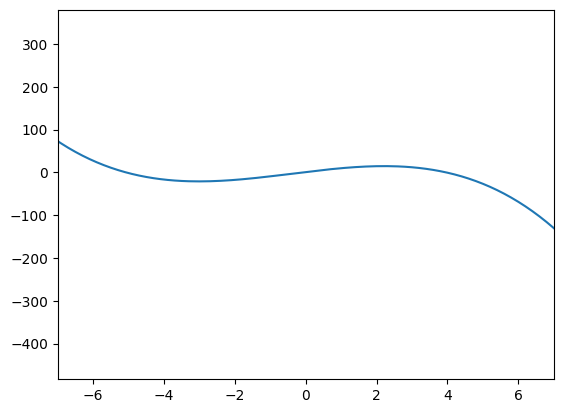

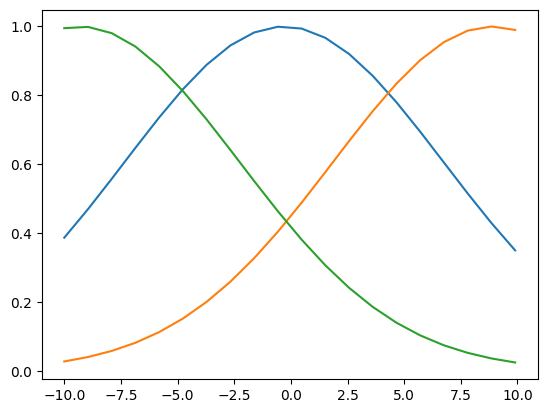

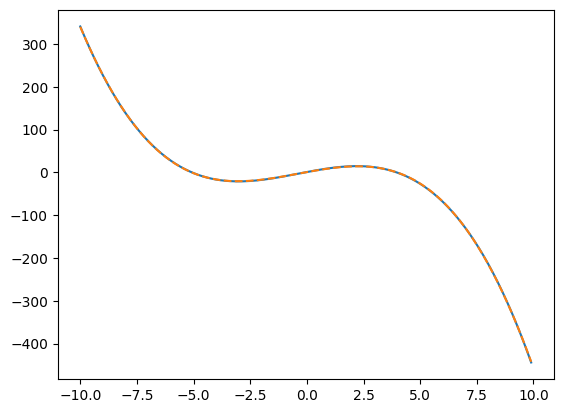

In [ ]:
#test genfis 1D
def my_exponential(A, B, C, x):
    return A*np.exp(-B*x)+C

data_x = np.arange(-10,10,0.1)
data_y = -0.5*data_x**3-0.6*data_x**2+10*data_x+1 #my_exponential(9, 0.5,1, data_x)

plt.plot(data_x, data_y)
# plt.ylim(-20,20)
plt.xlim(-7,7)

data = np.vstack((data_x, data_y)).T

fis2 = fis()
fis2.genfis(data, 1.1)
fis2.viewInputs()
r = fis2.evalfis(np.vstack(data_x))

plt.figure()
plt.plot(data_x,data_y)
plt.plot(data_x,r,linestyle='--')

fis2.solutions

# r1 = data_x*-2.29539539+ -41.21850973
# r2 = data_x*-15.47376916 -79.82911266
# r3 = data_x*-15.47376916 -79.82911266
# plt.plot(data_x,r1)
# plt.plot(data_x,r2)
# plt.plot(data_x,r3)

# Test genfis 2 entradas

--- 0.3469691276550293 seconds ---
nivel acti
[[3.38618175e-01 5.41007741e-03 3.81216813e-02 9.02055516e-02
  9.91704735e-01]
 [3.60147666e-01 6.10971052e-03 4.40675107e-02 9.00553967e-02
  9.96673600e-01]
 [3.81771846e-01 6.87686887e-03 5.07712605e-02 8.96064301e-02
  9.98335414e-01]
 ...
 [4.91893422e-02 7.80180556e-01 3.91515003e-02 2.06154197e-02
  7.37684005e-04]
 [4.47332264e-02 7.53357552e-01 3.86975750e-02 1.75977656e-02
  6.33913213e-04]
 [4.05454743e-02 7.25036925e-01 3.81216813e-02 1.49718625e-02
  5.42927945e-04]]
sumMu
[[1.46406022]
 [1.49705388]
 [1.52736182]
 ...
 [0.8898745 ]
 [0.85502003]
 [0.81921887]]
[  5.86288805   9.25873343 -37.29981739  -1.39631292  -5.76847075
 -80.12603747  11.52297151 -11.43525169 180.45790836 -10.69454417
 -12.33979411   5.48324203  13.69722831   6.93651714 114.99860553]


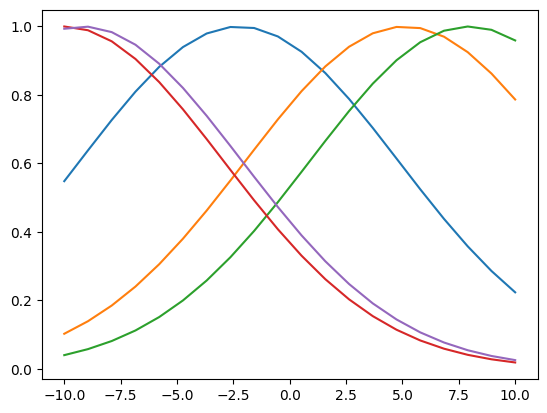

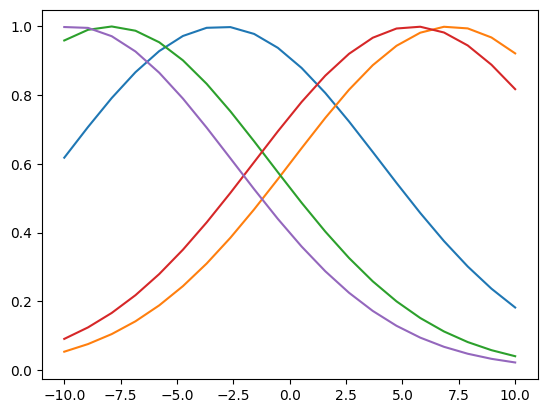

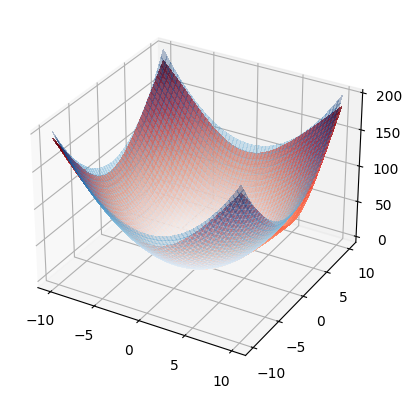

In [ ]:
from matplotlib import cm

x=np.linspace(-10,10,50)
X,Y = np.meshgrid(x,x)
Z = X**2+Y**2

data = np.vstack((X.ravel(), Y.ravel(), Z.ravel())).T

fis3 = fis()
fis3.genfis(data,1.2)
fis3.viewInputs()

r = fis3.evalfis(np.vstack((X.ravel(), Y.ravel())).T)
r = np.reshape(r, X.shape)


fig = plt.figure()
ax = fig.add_subplot(projection = '3d') #fig.gca(projection='3d')
surf = ax.plot_surface(X,Y,Z, cmap=cm.Blues,
                        linewidth=0, antialiased=False, alpha=0.3)

surf = ax.plot_surface(X,Y, r, cmap=cm.Reds,
                        linewidth=0, antialiased=False, alpha=0.8)


In [ ]:
fis2.rules

array([[-0.3],
       [ 8.9],
       [-9.3]])

In [ ]:
fis3.rules

array([[ -2.24489796,  -3.06122449],
       [  5.10204082,   7.14285714],
       [  7.95918367,  -7.95918367],
       [-10.        ,   5.51020408],
       [ -9.18367347,  -9.59183673]])